In [1]:
#!/usr/bin/env python

from __future__ import division
#%matplotlib inline

import tensornetwork as tn
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def genrandarr():
    num=[]
    num.append(np.random.rand(p,D))
    for i in range(1,N-1):
        num.append(np.random.rand(D,p,D))
    num.append(np.random.rand(D,p))
    return num

In [3]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    
    c[0][1] ^ c[1][0]
    for i in range (1,N-1):
        c[i][2] ^ c[i+1][0]
    
    return c

In [4]:
def createSigmaNode(ind):
    if ind==0:
        sigmanode = tn.Node(np.array([[1,0],[0,1]],dtype=np.complex_))
    elif ind==1:
        sigmanode = tn.Node(np.array([[0,1],[1,0]],dtype=np.complex_))
    elif ind==2:
        sigmanode = tn.Node(np.array([[0,-1j],[1j,0]],dtype=np.complex_))
    elif ind==3:
        sigmanode = tn.Node(np.array([[1,0],[0,-1]],dtype=np.complex_))
    return sigmanode

In [5]:
def getHeff(num,a):
    mps1 = createMPS(num)
    p1 = mps1[a]
    if a==0:
        r1 = mps1[1]
        for i in range(2,N):
            r1 = r1 @ mps1[i]
        summ = g*calc4a(p1,r1,1,a) + h*calc4a(p1,r1,3,a) - sscalc4a(p1,r1,a)
    elif a==N-1:
        l1 = mps1[0]
        for i in range(1,N-1):
            l1 = l1 @ mps1[i]
        summ = g*calc4b(l1,p1,1,a) + h*calc4b(l1,p1,3,a) - sscalc4b(l1,p1,a)
    else:
        l1 = mps1[0]
        r1 = mps1[a+1]
        for i in range(1,a):
            l1 = l1 @ mps1[i]
        for i in range(a+2,N):
            r1 = r1 @ mps1[i]
        summ = g*calc6(l1,p1,r1,1,a) + h*calc6(l1,p1,r1,3,a) - sscalc6(l1,p1,r1,a)
    return summ

In [6]:
def calc6(l1,p1,r1,ind,a):
    q=D*p*D
    summ = np.zeros((q,q),dtype=np.complex_)
    for k in range(N):
        curl1 = tn.Node(l1.tensor)
        curp1 = tn.Node(p1.tensor)
        curr1 = tn.Node(r1.tensor)
        
        curl2 = tn.Node(np.conj(l1.tensor))
        curp2 = tn.Node(np.conj(p1.tensor))
        curr2 = tn.Node(np.conj(r1.tensor))
    
    
        curl1[a] ^ curp1[0]
        curp1[2] ^ curr1[0]
        curl2[a] ^ curp2[0]
        curp2[2] ^ curr2[0]
        
        s = createSigmaNode(ind)
        
        for i in range(a):
            if i==k:
                curl1[i] ^ s[0]
                s[1] ^ curl2[i]
            else:
                curl1[i] ^ curl2[i]
        if a==k:
            curp1[1] ^ s[0]
            s[1] ^ curp2[1]
        else:
            curp1[1] ^ curp2[1]

        for i in range(1,N-a):
            if a+i==k:
                curr1[i] ^ s[0]
                s[1] ^ curr2[i]
            else:
                curr1[i] ^ curr2[i]
        
        op=np.identity(p,dtype=np.complex_)
        if k<a:
            curl1 = curl1 @ s
        elif k==a:
            op=s.tensor
        else:
            curr1 = curr1 @ s
        
        curl = curl1 @ curl2
        curr = curr1 @ curr2
        
        summ += vecmatrvecmiddle(curl.tensor,op,curr.tensor)
    return summ

In [7]:
def sscalc6(l1,p1,r1,a):
    q=D*p*D
    summ = np.zeros((q,q),dtype=np.complex_)
    for k in range(N):
        if k!=N-1:
            g1=k
            g2=k+1
        else:
            g1=N-1
            g2=0
        curl1 = tn.Node(l1.tensor)
        curp1 = tn.Node(p1.tensor)
        curr1 = tn.Node(r1.tensor)
        
        curl2 = tn.Node(np.conj(l1.tensor))
        curp2 = tn.Node(np.conj(p1.tensor))
        curr2 = tn.Node(np.conj(r1.tensor))
        
        curl1[a] ^ curp1[0]
        curp1[2] ^ curr1[0]
        curl2[a] ^ curp2[0]
        curp2[2] ^ curr2[0]
        
        s1 = createSigmaNode(3)
        s2 = createSigmaNode(3)
        
        for i in range(a):
            if i==g1:
                curl1[i] ^ s1[0]
                s1[1] ^ curl2[i]
            elif i==g2:
                curl1[i] ^ s2[0]
                s2[1] ^ curl2[i]
            else:
                curl1[i] ^ curl2[i]
        if a==g1:
            curp1[1] ^ s1[0]
            s1[1] ^ curp2[1]
        elif a==g2:
            curp1[1] ^ s2[0]
            s2[1] ^ curp2[1]
        else:
            curp1[1] ^ curp2[1]

        for i in range(1,N-a):
            if a+i==g1:
                curr1[i] ^ s1[0]
                s1[1] ^ curr2[i]
            elif a+i==g2:
                curr1[i] ^ s2[0]
                s2[1] ^ curr2[i]
            else:
                curr1[i] ^ curr2[i]
        
        op=np.identity(p,dtype=np.complex_)
        
        if g1<a:
            curl1 = curl1 @ s1
        elif g1==a:
            op=s1.tensor
        else:
            curr1 = curr1 @ s1
            
        if g2<a:
            curl1 = curl1 @ s2
        elif g2==a:
            op=s2.tensor
        else:
            curr1 = curr1 @ s2
        
        curl = curl1 @ curl2
        curr = curr1 @ curr2
        
        
        
        
        summ += vecmatrvecmiddle(curl.tensor,op,curr.tensor)
    return summ

In [8]:
def calc4a(p1,r1,ind,a):
    q=p*D
    summ = np.zeros((q,q),dtype=np.complex_)
    for k in range(N):
        curp1 = tn.Node(p1.tensor)
        curr1 = tn.Node(r1.tensor)
        
        curp2 = tn.Node(np.conj(p1.tensor))
        curr2 = tn.Node(np.conj(r1.tensor))
        
        curp1[1] ^ curr1[0]
        curp2[1] ^ curr2[0]
        
        s = createSigmaNode(ind)
        
        if k==0:
            curp1[0] ^ s[0]
            s[1] ^ curp2[0]
        else:
            curp1[0] ^ curp2[0]
        
        for i in range(1,N):
            if i==k:
                curr1[i] ^ s[0]
                s[1] ^ curr2[i]
            else:
                curr1[i] ^ curr2[i]
        
        op=np.identity(p,dtype=np.complex_)
        if k==0:
            op=s.tensor
        else:
            curr1 = curr1 @ s
        
        curr = curr1 @ curr2
        
        summ += vecmatrvecleft(op,curr.tensor)
    return summ

In [9]:
def sscalc4a(p1,r1,a):
    q=p*D
    summ = np.zeros((q,q),dtype=np.complex_)
    for k in range(N):
        if k!=N-1:
            g1=k
            g2=k+1
        else:
            g1=N-1
            g2=0
        
        curp1 = tn.Node(p1.tensor)
        curr1 = tn.Node(r1.tensor)
        
        curp2 = tn.Node(np.conj(p1.tensor))
        curr2 = tn.Node(np.conj(r1.tensor))
        
        curp1[1] ^ curr1[0]
        curp2[1] ^ curr2[0]
        
        s1 = createSigmaNode(3)
        s2 = createSigmaNode(3)
        
        if g1==0:
            curp1[0] ^ s1[0]
            s1[1] ^ curp2[0]
        elif g2==0:
            curp1[0] ^ s2[0]
            s2[1] ^ curp2[0]
        else:
            curp1[0] ^ curp2[0]
        
        for i in range(1,N):
            if i==g1:
                curr1[i] ^ s1[0]
                s1[1] ^ curr2[i]
            elif i==g2:
                curr1[i] ^ s2[0]
                s2[1] ^ curr2[i]
            else:
                curr1[i] ^ curr2[i]
        
        op=np.identity(p,dtype=np.complex_)
        
        if g1==0:
            op=s1.tensor
        else:
            curr1 = curr1 @ s1
            
        if g2==0:
            op=s2.tensor
        else:
            curr1 = curr1 @ s2
        
        curr = curr1 @ curr2
        
        summ += vecmatrvecleft(op,curr.tensor)
    return summ

In [10]:
def calc4b(l1,p1,ind,a):
    q=p*D
    summ = np.zeros((q,q),dtype=np.complex_)
    for k in range(N):
        curl1 = tn.Node(l1.tensor)
        curp1 = tn.Node(p1.tensor)
        
        curl2 = tn.Node(np.conj(l1.tensor))
        curp2 = tn.Node(np.conj(p1.tensor))
        
        curl1[N-1] ^ curp1[0]
        curl2[N-1] ^ curp2[0]
        
        s = createSigmaNode(ind)
        
        
        
        for i in range(N-1):
            if i==k:
                curl1[i] ^ s[0]
                s[1] ^ curl2[i]
            else:
                curl1[i] ^ curl2[i]
        
        if k==N-1:
            curp1[1] ^ s[0]
            s[1] ^ curp2[1]
        else:
            curp1[1] ^ curp2[1]
            
        op=np.identity(p,dtype=np.complex_)
        if k<N-1:
            curl1 = curl1 @ s
        else:
            op=s.tensor
        
        curl = curl1 @ curl2    
        
        summ += vecmatrvecright(curl.tensor,op)
    return summ

In [11]:
def sscalc4b(l1,p1,a):
    q=p*D
    summ = np.zeros((q,q),dtype=np.complex_)
    for k in range(N):
        if k!=N-1:
            g1=k
            g2=k+1
        else:
            g1=N-1
            g2=0
        
        curl1 = tn.Node(l1.tensor)
        curp1 = tn.Node(p1.tensor)
        
        curl2 = tn.Node(np.conj(l1.tensor))
        curp2 = tn.Node(np.conj(p1.tensor))
        
        curl1[N-1] ^ curp1[0]
        curl2[N-1] ^ curp2[0]
        
        s1 = createSigmaNode(3)
        s2 = createSigmaNode(3)
        
        
        
        for i in range(N-1):
            if i==g1:
                curl1[i] ^ s1[0]
                s1[1] ^ curl2[i]
            elif i==g2:
                curl1[i] ^ s2[0]
                s2[1] ^ curl2[i]
            else:
                curl1[i] ^ curl2[i]
        
        if g1==N-1:
            curp1[1] ^ s1[0]
            s1[1] ^ curp2[1]
        elif g2==N-1:
            curp1[1] ^ s2[0]
            s2[1] ^ curp2[1]
        else:
            curp1[1] ^ curp2[1]
            
        op=np.identity(p,dtype=np.complex_)
        
        if g1<N-1:
            curl1 = curl1 @ s1
        else:
            op=s1.tensor
        
        if g2<N-1:
            curl1 = curl1 @ s2
        else:
            op=s2.tensor
        
        curl = curl1 @ curl2    
        
        summ += vecmatrvecright(curl.tensor,op)
    return summ

In [12]:
def vecmatrvecmiddle(a0,a1,a2):
    q=D*p*D
    G = np.zeros((q,q),dtype=np.complex_)
    I=0
    J=0
    for i in range(D):
        for j in range(p):
            for k in range(D):
                for l in range(D):
                    for m in range(p):
                        for n in range(D):
                            G[I][J] = a0[i][l]*a1[j][m]*a2[k][n]
                            J=J+1
                I=I+1
                J=0
    return G

In [13]:
def vecmatrvecleft(a0,a1):
    q=p*D
    G = np.zeros((q,q),dtype=np.complex_)
    I=0
    J=0
    for i in range(p):
        for j in range(D):
            for l in range(p):
                for m in range(D):
                    G[I][J] = a0[i][l]*a1[j][m]
                    J=J+1
            I=I+1
            J=0
    return G

In [14]:
def vecmatrvecright(a0,a1):
    q=D*p
    G = np.zeros((q,q),dtype=np.complex_)
    I=0
    J=0
    for i in range(D):
        for j in range(p):
            for l in range(D):
                for m in range(p):
                    G[I][J] = a0[i][l]*a1[j][m]
                    J=J+1
            I=I+1
            J=0
    return G

In [15]:
def getNop(num,a):
    mps1 = createMPS(num)
    mps2 = createMPS(num)
    for i in range(N):
        mps2[i].tensor = np.conj(mps2[i].tensor)
    mps1[0][0] ^ mps2[0][0]
    for i in range(1,N):
        mps1[i][1] ^ mps2[i][1]
    iden=np.identity(p,dtype=np.complex_)
    if a==0:
        r = rightcollapsePsiPsi(mps1,mps2,1)
        return vecmatrvecleft(iden,r.tensor)
    elif a==N-1:
        r = leftcollapsePsiPsi(mps1,mps2,N-2)
        return vecmatrvecright(r.tensor,iden)
    else:
        r1 = leftcollapsePsiPsi(mps1,mps2,a-1)
        r2 = rightcollapsePsiPsi(mps1,mps2,a+1)
        return vecmatrvecmiddle(r1.tensor,iden,r2.tensor)

In [16]:
def leftcollapsePsiPsi(mps1,mps2,r):
    node = mps1[0] @ mps2[0]
    for i in range(1,r+1):
        node = node @ mps1[i]
        node = node @ mps2[i]
    return node

In [17]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node

In [18]:
def Avectomatr(vec,l):
    I=0
    if l==0:
        matr = np.zeros((p,D),dtype=np.complex_)
        for i in range(p):
            for j in range(D):
                matr[i][j]=vec[I]
                I=I+1
    elif l==N-1:
        matr = np.zeros((D,p),dtype=np.complex_)
        for i in range(D):
            for j in range(p):
                matr[i][j]=vec[I]
                I=I+1
    else:
        matr = np.zeros((D,p,D),dtype=np.complex_)
        for i in range(D):
            for j in range(p):
                for k in range(D):
                    matr[i][j][k]=vec[I]
                    I=I+1
    return matr

In [19]:
def calcEnergy(num):
    mps1 = createMPS(num)
    up = mps1[0]
    for i in range(1,N):
        up = up @ mps1[i]
    E = g*calc2(up,1) + h*calc2(up,3) - sscalc2(up)
    return E

In [20]:
def calc2(up,ind):
    ans = 0
    for k in range(N):
        curup = tn.Node(up.tensor)
        curdown = tn.Node(np.conj(up.tensor))
        
        s = createSigmaNode(ind)
        
        for i in range(N):
            if i==k:
                curup[i] ^ s[0]
                s[1] ^ curdown[i]
            else:
                curup[i] ^ curdown[i]
        ans += (curup @ s @ curdown).tensor
    return ans

In [21]:
def sscalc2(up):
    ans = 0
    for k in range(N):
        
        if k!=N-1:
            g1=k
            g2=k+1
        else:
            g1=N-1
            g2=0
        
        curup = tn.Node(up.tensor)
        curdown = tn.Node(np.conj(up.tensor))
        
        s1 = createSigmaNode(3)
        s2 = createSigmaNode(3)
        
        for i in range(N):
            if i==g1:
                curup[i] ^ s1[0]
                s1[1] ^ curdown[i]
            elif i==g2:
                curup[i] ^ s2[0]
                s2[1] ^ curdown[i]
            else:
                curup[i] ^ curdown[i]        
        ans += (curup @ s1 @ s2 @ curdown).tensor
    return ans

In [22]:
def getrhoin(num,k):
    mps1 = createMPS(num)
    mps2 = createMPS(num)
    for i in range(N):
        mps2[i].tensor = np.conj(mps2[i].tensor)
    for i in range(k+1,N):
        mps1[i][1] ^ mps2[i][1]
    a = rightcollapsePsiPsi(mps1,mps2,k+1)
    a = tn.Node(a.tensor)
    up = mps1[0]
    for i in range(1,k+1):
        up = up @ mps1[i]
    up = tn.Node(up.tensor)
    down = tn.Node(np.conj(up.tensor))
    up[k+1] ^ a[0]
    a[1] ^ down[k+1]
    tens = up @ a @ down
    rhoin = np.reshape(tens.tensor,(p**(k+1),p**(k+1)))    
    return rhoin

In [23]:
def calcEntr(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = sp.linalg.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [42]:
def printEntr(m):
    entr=[]
    for k in range(0,N-1):
        entrcur = calcEntr(getrhoin(m,k))
        entrcur = entrcur
        print('Entanglement entropy ( position = ',k,'):',np.real(np.around(entrcur,decimals=6)))
        entr.append(entrcur)
    arange = np.arange(N-1)
    f = plt.figure(figsize=(18, 10))
    plt.scatter(arange, entr, s=50, marker='o', color='IndianRed')
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement Entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [43]:
def func():
    print()
    print('g =',g)
    print('h =',h)
    for a in range(avnum):
        m=genrandarr()
        aloc=0
        for i in range(itnum):
            Nop=getNop(m,aloc)
            Heff=getHeff(m,aloc)
            u=sp.linalg.eig(Heff,Nop)
            eigval=u[0]
            eigvec=u[1]
            mineigval=eigval[0]
            mineigvalind=0
            for j in range(1,len(eigval)):
                if eigval[j]<mineigval:
                    mineigval=eigval[j]
                    mineigvalind=j
            v=Avectomatr(eigvec[mineigvalind],aloc)
            m[aloc] = v
            if aloc!=N-1:
                aloc += 1
            else:
                aloc = 0
        EnCur = calcEnergy(m)
        print('Energy =',np.real(np.around(EnCur,decimals=6)))
        printEntr(m)

H = -ZZ + hZ + gX
N = 12

g = 1.05
h = 0
Energy = -2.0775
Entanglement entropy ( position =  0 ): 0.264998
Entanglement entropy ( position =  1 ): 0.529995
Entanglement entropy ( position =  2 ): 0.794993
Entanglement entropy ( position =  3 ): 1.059991
Entanglement entropy ( position =  4 ): 1.324989
Entanglement entropy ( position =  5 ): 1.589986
Entanglement entropy ( position =  6 ): 1.854984
Entanglement entropy ( position =  7 ): 2.119982
Entanglement entropy ( position =  8 ): 2.384979
Entanglement entropy ( position =  9 ): 2.649977
Entanglement entropy ( position =  10 ): 2.914975


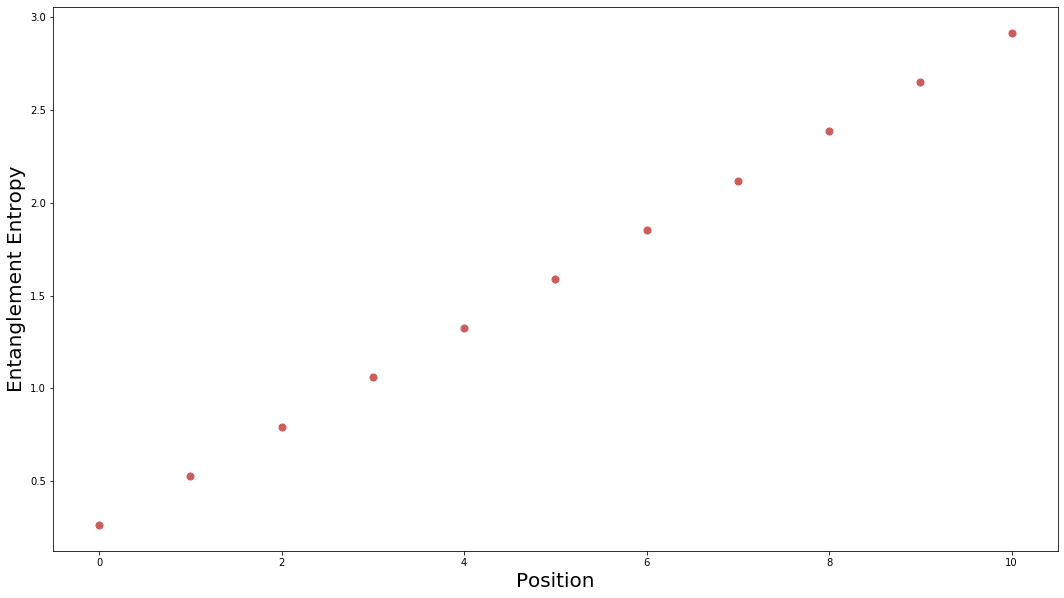


g = 1.05
h = 0.1
Energy = -3.829915
Entanglement entropy ( position =  0 ): 0.243049
Entanglement entropy ( position =  1 ): 0.486097
Entanglement entropy ( position =  2 ): 0.729146
Entanglement entropy ( position =  3 ): 0.972195
Entanglement entropy ( position =  4 ): 1.215244
Entanglement entropy ( position =  5 ): 1.458292
Entanglement entropy ( position =  6 ): 1.701341
Entanglement entropy ( position =  7 ): 1.94439
Entanglement entropy ( position =  8 ): 2.187438
Entanglement entropy ( position =  9 ): 2.430487
Entanglement entropy ( position =  10 ): 2.673536


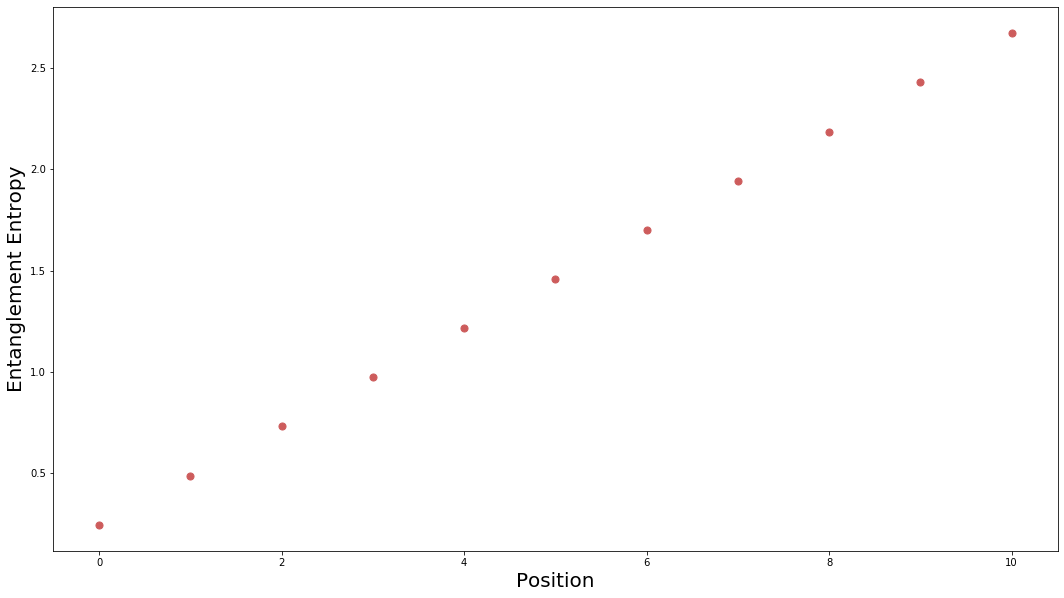


g = 1.05
h = 0.5
Energy = -10.239728
Entanglement entropy ( position =  0 ): 0.181688
Entanglement entropy ( position =  1 ): 0.363376
Entanglement entropy ( position =  2 ): 0.545064
Entanglement entropy ( position =  3 ): 0.726752
Entanglement entropy ( position =  4 ): 0.90844
Entanglement entropy ( position =  5 ): 1.090128
Entanglement entropy ( position =  6 ): 1.271816
Entanglement entropy ( position =  7 ): 1.453504
Entanglement entropy ( position =  8 ): 1.635192
Entanglement entropy ( position =  9 ): 1.81688
Entanglement entropy ( position =  10 ): 1.998568


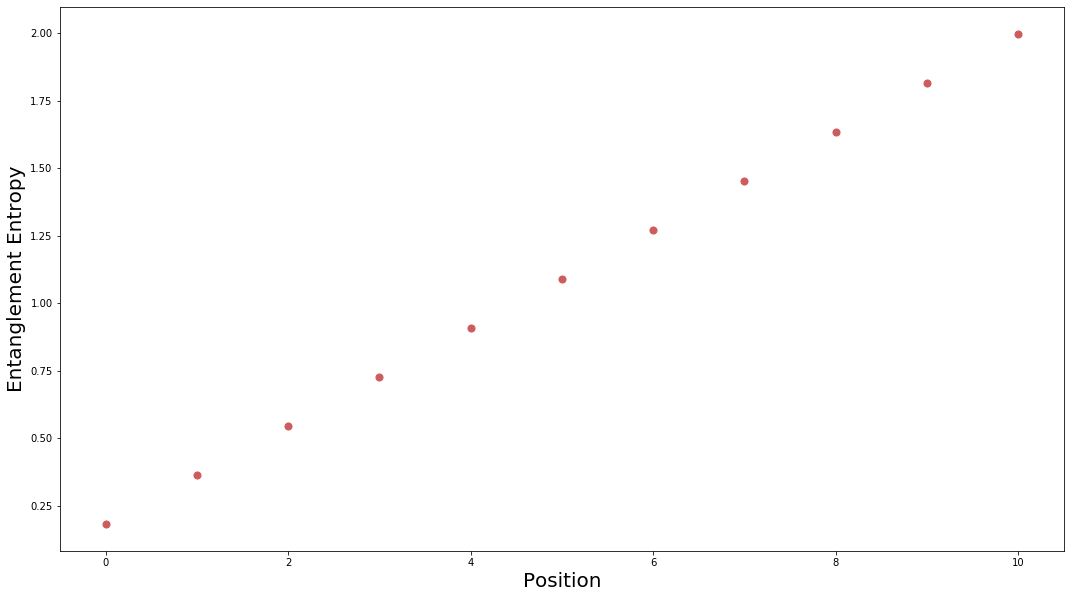

In [45]:
print('H = -ZZ + hZ + gX')
N = 12 #длина цепочки
print('N =',N)
D = 1 #bond index
p = 2 #выходящий индекс
itnum = 1000 #число итераций для нахождения ground state
avnum = 1
h = 0
func()
h = 0.1
func()
h = 0.5
func()